In [1]:
import numpy as np
import pandas as pd
import os, sys
import seaborn as sns
import matplotlib.pyplot as plt 

folder needs to be defined for the analysis to run

In [2]:
#expDir = "./"
#folder1 = expDir+"output/BZ7872/"
#folder2 = expDir+"output/BZ7873/"

In [30]:
expDir = "./"
folder1 = expDir+"output/BZ7876/"
folder2 = expDir+"output/BZ7877/"
folder3 = expDir+"output/BZ7879/"

The following parameters can be found in the table: ampl, bg, id (?),	dr, 	sigma,	time,	numCells,	Position (on the chip). Additionally, I need to add which strain has been imaged in which position. As we image the different sides in an alternating fashion, either even or odd position numbers were used for one of the strains. 

In [31]:
def normalize_times_add_parameters(folder, OSym="even", run=2, protein="WT", IPTG="0.3 mM", replica =1, switching_time=0):
    """Reads the result from ImAnalysis, adds information on the experiment and time of the run.
    
        Parameters:        
            folder (str):the folder with the data.
            OSym (str): even or odd dependent on positions with the strain having even or odd numbers.
            run (int): number of the run to be analysed.
            protein (str): defined the protein mutant ("WT", "V52A" or "Q55N") contained in the cells.
            IPTG (str): defines the IPTG concentration used in the experiment.
            switching_time (int): time (s) of the media switch

        Returns:
            df (pandas DF): dataframe that contains the data from the image analysis with the time in s and specifics 
                about the experiment.

    """
    
    df = pd.read_excel(folder+'dots_run{}.xlsx'.format(run), engine='openpyxl')

    time1 = np.round(df.iloc[0]["time"]/1000)

    norm_time = np.round(df["time"]/1000)-time1-switching_time 
    df["Time (s)"] = norm_time
    
    max_pos = np.max(df["position"].values)
    
    if OSym=="even":
        strains = np.where( df["position"].isin(np.arange(1,max_pos+1,2)) , "term", "OSymL")
    if OSym=="odd":
        strains = np.where( df["position"].isin(np.arange(1,max_pos+1,2)) , "OSymL", "term")

    df["Run"] = [run for x in range(len(df))]
    df["Strain"] = strains
    df["Run"] = [run for x in range(len(df))]
    df["LacI"] = [protein for x in range(len(df))]
    df["IPTG"] = [IPTG for x in range(len(df))]
    df["Replica"] = [replica for x in range(len(df))]
    
    return(df)

In [33]:
def average_dot_counts(df): 
    """Counts and averages the number of dots per cell in each position.
    
            Parameters:
                df (pandas DataFrame): from normalizeTimesAddStrain(OSym="even" or "odd", run = X)

            Returns:
                avgNumDotsCells (pandas DataFrame):contains the averaged number of dots, runs id, strain, time (s), 
                                        IPTG and LacI mutant.
    """
    
    run=df
    avgNumDotsCells = np.array(run.groupby("position").count()["numCells"])/ \
    np.array(run.groupby("position").mean(numeric_only=True)["numCells"])

    time = np.array(run.groupby("position").first()["Time (s)"])
    strain = np.array(run.groupby("position").first()["Strain"])

    runs = np.array(run.groupby("position").first()["Run"])
    IPTG = np.array(run.groupby("position").first()["IPTG"])
    LacI = np.array(run.groupby("position").first()["LacI"])
    replica = np.array(run.groupby("position").first()["Replica"])
    
    avgNumDotsCells = pd.DataFrame({"Run":runs, "Strain":strain, "avg. N(Dots)/Cell": \
             avgNumDotsCells, "Time (s)": time, "IPTG": IPTG, "LacI": LacI, "Replica":replica})
    return(avgNumDotsCells)

In [39]:
def all_runs(folders, ids_runs, locs_OSym, protein="V52A", switching_time=0):
    """Combines the average number of cells record for all runs into one DF.
    
            Parameters:
                ids_runs (list): the ids of the runs to sumarize.
                locs_OSym (list): is Osym imaged from the even or odd positions?
                protein (str):  defines the protein mutant ("WT", "V52A" or "Q55N") contained in the cells.
                switching_time (int): time (s) of the media switch

            Returns:
                df_runs (pandas DataFrame): summarized data frame.

            Calls:
                normalize_times_add_parameters
                average_dot_counts
    """
    
    j=0
    df_list = []
    
    while j<len(folders):
        print(j)
        for i,m in zip(ids_runs[j], locs_OSym[j]):
                df = normalize_times_add_parameters(folders[j], OSym=m, run=i, replica=j+1,\
                                          protein=protein, switching_time=switching_time)
                runNum = average_dot_counts(df)
                df_list.append(runNum)
        j+=1
                
    df_runs = pd.concat(x for x in df_list)
    
    return(df_runs.reset_index())

In [40]:
#allR = allRuns([folder1,folder2,folder3,folder4],\
#                 [[1,3],[1,2,3,4],[1,2,3,4,5,6],[4,5,6,7,8,9,10]],\
#                 [["odd","odd"],["odd","odd","odd","odd"],["odd","even","odd","odd","even","odd"],\
#                  ["even","odd","even","odd","even","even","odd"]],\
#                 protein="V52A",switching_time=10)

In [41]:
allR = all_runs([folder1,folder2,folder3,folder3],\
               [[1,4],[4,6,8,9],[2,3,4],[6,7,8]],\
               [["odd","odd","odd"],\
                ["even","even","even","even"],\
                ["even","odd","even"],["even","odd","even"]],\
               protein="V52A",switching_time=10)

0
1
2
3


For the analysis, the switch happens after 10 s. For binding curves 10 s should be substratected from the times and negative time stemps should be skipped. 
Additionally, I want to substract the non-specific binding (in the cells without the operator) from the mixed binding (in the cells with the operator) for the wt strain. For this I want to use the points that are closest.

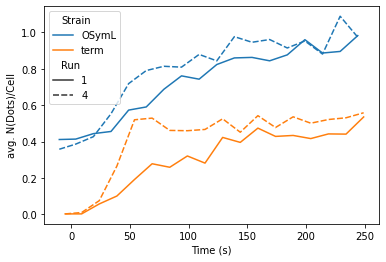

In [9]:
sns.lineplot(data=allR[allR["Replica"]==1].sort_values('Strain'), x = "Time (s)", y = "avg. N(Dots)/Cell", hue = "Strain", style = "Run")
plt.savefig("figures/binding_curves_BZ7976.png")

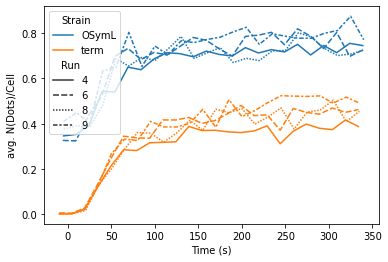

In [10]:
sns.lineplot(data=allR[allR["Replica"]==2].sort_values('Strain'), x = "Time (s)", y = "avg. N(Dots)/Cell", hue = "Strain", style = "Run")
plt.savefig("figures/binding_curves_BZ7977.png")

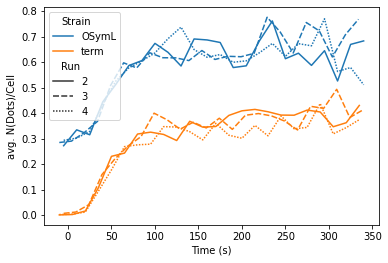

In [11]:
sns.lineplot(data=allR[allR["Replica"]==3].sort_values('Strain'), x = "Time (s)", y = "avg. N(Dots)/Cell", hue = "Strain", style = "Run")
plt.savefig("figures/binding_curves_BZ7979.png")

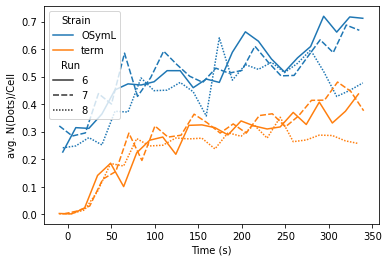

In [12]:
sns.lineplot(data=allR[allR["Replica"]==4].sort_values('Strain'), x = "Time (s)", y = "avg. N(Dots)/Cell", hue = "Strain", style = "Run")
plt.savefig("figures/binding_curves_BZ7979_2.png")

In [17]:
def interpolate(df, j, i):
    """Get the linear interpolation between non-specific dots to substract from the mixed binding.
    
        Parameters:
            df (pandas DataFrame):
                contains data from microscopy
            j (int):
                replica (different days of the experiments, different chips, etc.)
            i (int):
                run (imaged on the same chip)
        
        Returns:
            lininp (numpy array):
                contains the interpolated values of non-specific bindings to match the time of the mixed one.
    """
    
    SymL = df[(df["Strain"] == "OSymL") & (df["Replica"] ==  j) ]
    term = df[(df["Strain"] == "term")& (df["Replica"] ==  j) ]
    
    lininp = np.interp(SymL[SymL["Run"]==i]["Time (s)"].values,\
                      term[term["Run"]==i]["Time (s)"].values,\
                      term[term["Run"]==i]["avg. N(Dots)/Cell"].values)
    return(lininp)

def checkFit(df, j, i):
    """Plot the data and the fitted cubic spline as well as the result from substraction (specific binding).
    
        Parameters:
            df (pandas DataFrame):
                contains data from microscopy
            j (int):
                replica (different days of the experiments, different chips, etc.)
            i (int):
                run (imaged on the same chip)"""
    
    SymL = df[(df["Strain"] == "OSymL") & (df["Replica"] ==  j) ]
    term = df[(df["Strain"] == "term")& (df["Replica"] ==  j) ]
    
    interp = interpolate(df, j, i)
    
    plt.plot(SymL[SymL["Run"]==i]["Time (s)"].values, interp, label='interpolation')
    plt.plot(term[term["Run"]==i]["Time (s)"].values,\
             term[term["Run"]==i]["avg. N(Dots)/Cell"].values, label="data term")
    plt.plot(SymL[SymL["Run"]==i]["Time (s)"].values,\
             SymL[SymL["Run"]==i]["avg. N(Dots)/Cell"].values, label="data OSymL")
    plt.plot(SymL[SymL["Run"]==i]["Time (s)"].values,\
             SymL[SymL["Run"]==i]["avg. N(Dots)/Cell"].values-interp, label="data specific")
    plt.legend()

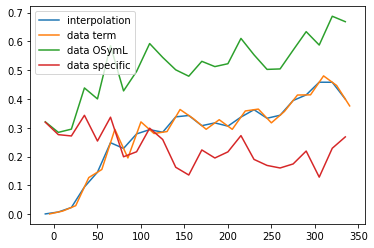

In [23]:
checkFit(allR,4,)

In [24]:
def calculateDeltaDots(df, LacI= "WT", IPTG="0.3 mM", ONPG=False ,runs = [1,2,3,4], replica = 1):
    """ Calculates the difference between number of dots in cells with and without operator --> specific binding.
    
    This works for a DataFrame that contains data from one or several experiments, where the relevant one is 
    extracted using the keywords. The time is adjusted by substracting the time of the media switch.

    The number of dots for the empty strain is substracted from the one with the operator. 
    As the data for the two strain cannot be recordet at the same time, the curves for the control strain
    are fitted using a cubic splines first. The curves serve to calculate the expected number of dots recorded 
    at the same time as the image for the operator containing strain was recorded.
    
    Finally the curves of the runs (Usually 4 runs per experiment) are averaged to obtain a mean curve and 
    standard deviation.
    
        Parameters:
            df (pandas DataFrame): contains the data from the microscopy experiment, where the strain and conditions are defined.
            LacI (str):defines the protein
            IPTG (str):defines the IPTG concentration in the media
            ONPG (bol, str):False when no ONPG has been used, otherwise the ONPG concentration
            runs (int):number of runs analysed for the df
            switching_time (int):time (s) of the media switch
    
        Return:
            dDots (pandas DataFrame): 
    """

    # get the experiments 
    if ONPG==True:
        rr_LacI = df[(df["IPTG"]==IPTG)&(df["LacI"]==LacI)&(df["ONPG"]==ONPG) & (df["Replica"]==replica) & (df["Run"].isin(runs))]
    else:
        rr_LacI = df[(df["IPTG"]==IPTG)&(df["LacI"]==LacI) & (df["Replica"]==replica) & (df["Run"].isin(runs))]
    
    # correct the time to 0 at the switch 
    rr_LacI_ = rr_LacI.copy()
    #rr_LacI_["Time (s)"] = rr_LacI["Time (s)"]-switching_time # Here you want a first point at 0
    
    #  exchange negative times with 0
    rr_LacI_.loc[rr_LacI_["Time (s)"] <0 , "Time (s)"] = 0
        
    # split the frame according to strain
    rr_LacI_OSymL = rr_LacI_[rr_LacI_["Strain"] == "OSymL"]
    rr_LacI_term = rr_LacI_[rr_LacI_["Strain"] == "term"]

    # calculate the difference between the average number of dots per cell in strains with and without operator
    relNdots = []

    for i in runs:
        # interpolate the number of non-specific dots for the specific binding time points    
        new_term_points = interpolate(rr_LacI_, replica, i)
        
        relNdots.append(np.array(rr_LacI_OSymL[rr_LacI_OSymL["Run"]==i]["avg. N(Dots)/Cell"])-new_term_points)
    rr_LacI_OSymL_rel = rr_LacI_OSymL.copy()
    rr_LacI_OSymL_rel["$\Delta$ avg. N(dots)/cell"] =  [x for i in relNdots for x in i]

    return(rr_LacI_OSymL_rel)

In [25]:
#[1,3,4],[4,6,8,9],[2,3,4,6,7,8]
relD_rep1 = calculateDeltaDots(allR,replica=1,runs=[1,4],LacI="V52A")
relD_rep2 = calculateDeltaDots(allR,replica=2,runs=[4,6,8,9],LacI="V52A")
relD_rep3 = calculateDeltaDots(allR,replica=3,runs=[2,3,4],LacI="V52A")
relD_rep4 = calculateDeltaDots(allR,replica=4,runs=[6,7,8],LacI="V52A")

<AxesSubplot:xlabel='Time (s)', ylabel='$\\Delta$ avg. N(dots)/cell'>

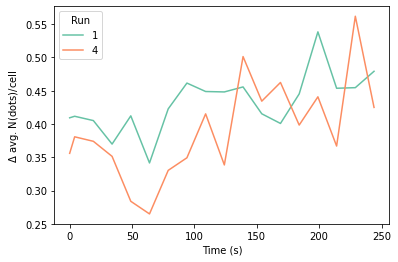

In [26]:
sns.lineplot(data = relD_rep1, x = "Time (s)",y = "$\Delta$ avg. N(dots)/cell", hue= "Run",\
           palette="Set2" )

<AxesSubplot:xlabel='Time (s)', ylabel='$\\Delta$ avg. N(dots)/cell'>

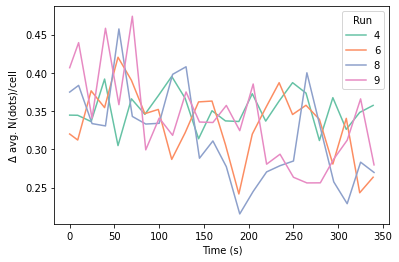

In [27]:
sns.lineplot(data =relD_rep2, x = "Time (s)",y = "$\Delta$ avg. N(dots)/cell", hue= "Run",\
           palette="Set2" )

<AxesSubplot:xlabel='Time (s)', ylabel='$\\Delta$ avg. N(dots)/cell'>

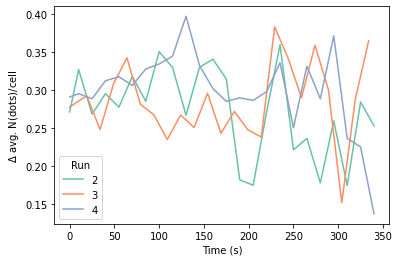

In [28]:
sns.lineplot(data =relD_rep3, x = "Time (s)",y = "$\Delta$ avg. N(dots)/cell", hue= "Run",\
           palette="Set2" )

<AxesSubplot:xlabel='Time (s)', ylabel='$\\Delta$ avg. N(dots)/cell'>

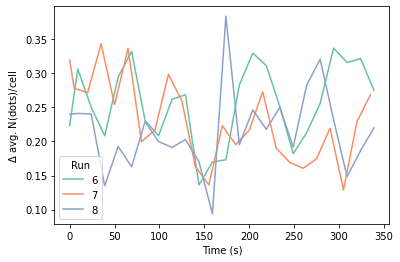

In [29]:
sns.lineplot(data =relD_rep4, x = "Time (s)",y = "$\Delta$ avg. N(dots)/cell", hue= "Run",\
           palette="Set2" )

In [ ]:
sns.lineplot(data =pd.concat([relD_rep1,relD_rep2,relD_rep3]), x = "Time (s)",y = "$\Delta$ avg. N(dots)/cell", hue= "Replica",\
           palette="Set2" )
plt.savefig("figures/OSymL_V52A_binding_curves_IPTG.png")

In [145]:
def func(x, a, b, k):
    return a * (1- b * np.exp(-k * (x) ) )
def fit_curve(df, p0=(1,3,0.01), skipFirst=0, LacI="WT"):
    
    from scipy.optimize import curve_fit
    
    DDots = df[df["LacI"]==LacI]["$\Delta$ avg. N(dots)/cell"]
    #QDDots = df[df["LacI"]=="Q55N"]["$\Delta$ avg. N(dots)/cell"]
    
    Time = df[df["LacI"]==LacI]["Time (s)"]
    #QTime = df[df["LacI"]=="Q55N"]["Time (s)"]
    
    x = Time.values
    #x_Q = QTime.values
    y = DDots.values
    plt.figure(figsize=(3.8,2.9))
    plt.plot(x, y, 'o', label="Data V52A", markersize=3)
    #y_Q = QDDots.values
    
    popt, pcov = curve_fit(func, x[skipFirst:], y[skipFirst:], p0=p0)
    #popt_Q, pcov_Q = curve_fit(func, x_Q[skipFirst:], y_Q[skipFirst:], p0=p0)
    
    print(popt)
    return(x, y, popt)

In [151]:
def func(x, a, b, k):
    return a * (1- b * np.exp(-k * (x) ) )
def fit_curve(df, p0=(1,3,0.01), skipFirst=0, LacI="WT"):
    
    from scipy.optimize import curve_fit
    
    DDots = df[df["LacI"]==LacI]["$\Delta$ avg. N(dots)/cell"]
    #QDDots = df[df["LacI"]=="Q55N"]["$\Delta$ avg. N(dots)/cell"]
    
    Time = df[df["LacI"]==LacI]["Time (s)"]
    #QTime = df[df["LacI"]=="Q55N"]["Time (s)"]
    
    x = Time.values
    #x_Q = QTime.values
    y = DDots.values
    plt.figure(figsize=(3.8,2.9))
    plt.plot(x, y, 'o', label="Data V52A", markersize=3)
    #y_Q = QDDots.values
    
    popt, pcov = curve_fit(func, x[skipFirst:], y[skipFirst:], p0=p0)
    #popt_Q, pcov_Q = curve_fit(func, x_Q[skipFirst:], y_Q[skipFirst:], p0=p0)
    
    print(popt)
    return(x, y, popt)

In [168]:
def fit_line(df, skipFirst=0, LacI="WT"):
    
    from scipy.stats import linregress
    
    DDots = df[df["LacI"]==LacI]["$\Delta$ avg. N(dots)/cell"]
    #QDDots = df[df["LacI"]=="Q55N"]["$\Delta$ avg. N(dots)/cell"]
    
    Time = df[df["LacI"]==LacI]["Time (s)"]
    #QTime = df[df["LacI"]=="Q55N"]["Time (s)"]
    
    x = Time.values
    #x_Q = QTime.values
    y = DDots.values
    #plt.figure(figsize=(3.8,2.9))
    #plt.plot(x, y, 'o', label="Data V52A", markersize=3)
    #y_Q = QDDots.values
    
    popt = linregress(x[skipFirst:], y[skipFirst:])
    #popt_Q, pcov_Q = curve_fit(func, x_Q[skipFirst:], y_Q[skipFirst:], p0=p0)
    
    print(popt)
    return(x, y, popt)

In [178]:
x, y, popt = fit_line(pd.concat([relD_rep1,relD_rep2,relD_rep3]),LacI="V52A",skipFirst=0)

LinregressResult(slope=-0.0001798485453386291, intercept=0.35974640511068784, rvalue=-0.2630915023817958, pvalue=0.00014364701739886604, stderr=4.6403272857713294e-05, intercept_stderr=0.008697888482379488)


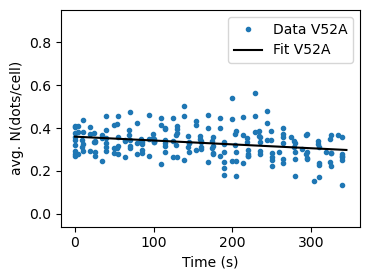

In [179]:
plt.figure(figsize=(3.8,2.9))
plt.plot(x, y, 'o', label="Data V52A", markersize=3)
plt.plot(np.arange(0,350,15), popt.intercept+popt.slope*np.arange(0,350,15), 'k-', label="Fit V52A")
#plt.plot(np.arange(0,350,15), func(np.arange(0,350,15), *popt_wt1), 'k-', label="Fit V52A")
plt.legend()
plt.ylim(-0.06,0.95)

plt.legend()
plt.ylabel("avg. N(dots/cell)")
plt.xlabel("Time (s)")
plt.tight_layout()

#plt.savefig("figures/OSymL_V52A_binding_curves_fitted_IPTG.png")